# A two period consumption-savings problem



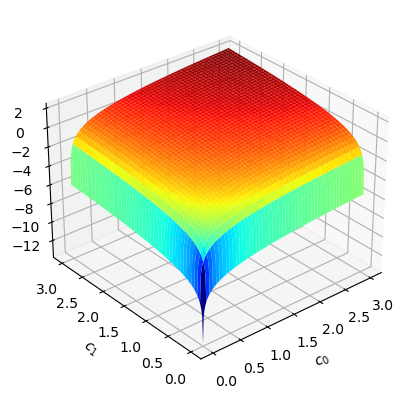

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm # for colormaps
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D # for 3d figures

## The period utility function
def u(c,σ):
    if σ ==1:
        out = np.log(c)
    else:
        out = (c**(1-σ)-1)/(1-σ)
    return out

def u_inv(x,σ):
    if σ==1:
        out = np.exp(x)
    else:
        out = (x*(1-σ)+1)**(1/(1-σ))
    return out

## Aggregate utility
def U(c1,c2,β,σ):
    out = u(c1,σ) + β*u(c2,σ)
    return out

β   = 0.96
r   = 0.05
y_1 = 1.5
y_2 = 2
σ   = 1

## The indifference curves
# A vector for consumption values
c_vec = np.linspace(10**(-10),3,1000)

# a. Create numbers distributed evenly between a small number and c_max
c_max = 3
N = 200
c_vec = np.linspace(0.001,c_max,N)

# b. Create meshgrids similar to x1_values and x2_values above
c1_mesh,c2_mesh = np.meshgrid(c_vec,c_vec,indexing='ij')

u_values_mesh = U(c1_mesh, c2_mesh, β,σ)


fig = plt.figure() # create the figure
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
ax.plot_surface(c1_mesh,c2_mesh,u_values_mesh,cmap=cm.jet); # create surface plot in the axis
ax.view_init(30, 230)
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_1$')
ax.set_zlabel('$U(c_0,c_1)$')
plt.savefig('3d_indiff.pdf')

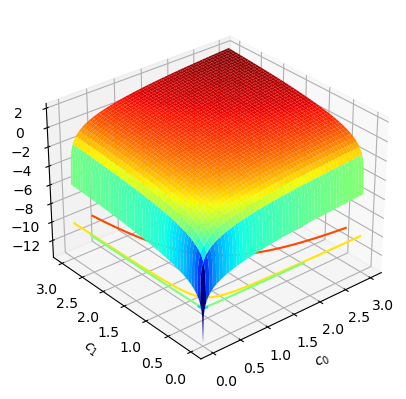

In [3]:
## Same figure again but with indifference curves on the bottom
fig = plt.figure() # create the figure
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d type axis 
ax.plot_surface(c1_mesh,c2_mesh,u_values_mesh,cmap=cm.jet); # create surface plot in the axis
ax.view_init(30, 230)
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_1$')
ax.set_zlabel('$U(c_0,c_1)$')

## Project indifference curves on the bottom of the figure 
NU   = 5 ## Number of indifference curve to plot
ax.contour(c1_mesh,c2_mesh,u_values_mesh, NU, cmap=cm.jet, linestyles="solid", offset=-10)
plt.savefig('3d_projection.pdf')

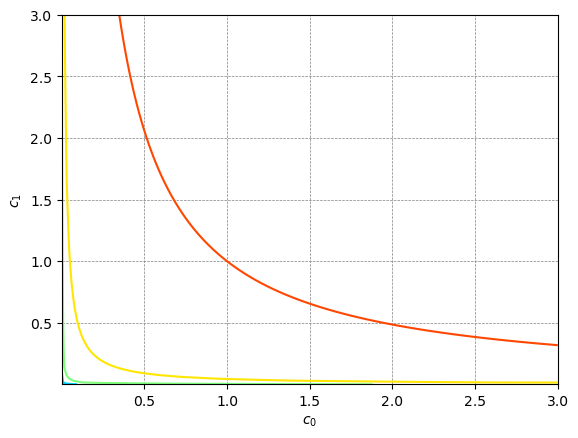

In [4]:
## Only indifference curves
fig,ax = plt.subplots() # create the figure
ax.contour(c1_mesh,c2_mesh,u_values_mesh, NU, cmap=cm.jet, linestyles="solid")
ax.set_xlabel('$c_0$')
ax.set_ylabel('$c_1$')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('2d_projection.pdf')

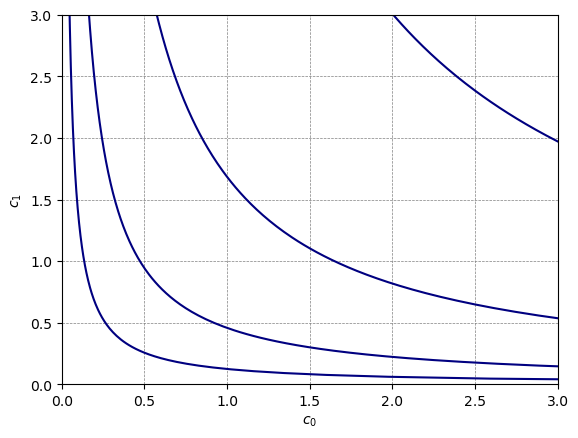

In [5]:
## Find the indifference curves and solve the problem
# max          U = u(c_1) + β u(c_2) 
# s.t. c_1 + a_1 = y_1 
#            c_2 = y_2 + (1+r) a_1

## This function is to be minimized (just inverted maximum, necessary for the solver)
def problemfun(a_1,y_1,y_2,β,r,σ):
    #Overall utility function, with budget constraints plugged in for c_2 and c_2
    U = u(y_1-a_1,σ) + β*u(y_2+ (1+r)*a_1,σ)
    return -U

## Function that plots NU indifference curves for utilities [lowb,upb], given values of c_1 (c1vec)
def plot_indifference(NU, lowb, upb,β,σ, c_vec,cc ,ll = 'solid'):
    U_vec = np.linspace(lowb,upb,NU)
    for iU in range(U_vec.size):
        value = U_vec[iU]
        ## This recovers the whole indifference curve for U = value by solving the problem for c_1
        c1vec = u_inv(value - β*u(c_vec,σ),σ )
        plt.plot(c1vec,c_vec,color=cc, linestyle = ll)
        plt.xlim(0,c_max)
        plt.ylim(0,c_max)
    plt.xlabel('$c_0$')
    plt.ylabel('$c_1$')

## Function for σ!=1, because solution is *very* unstable
def plot_indifference_sigma(NU, lowb, upb,β,σ,cc ,ll = 'solid'):
    U_vec = np.linspace(lowb,upb,NU)
    for iU in range(U_vec.size):
        value = U_vec[iU]
        ## At large values of c_0, c_1 asymptotes at this value. There is no point in solve for lower c_1 values
        c1min = u_inv((value - u(1000,σ))/β,σ )
        c_vec = np.linspace(c1min, c_max, N)
        ## This recovers the whole indifference curve for U = value by solving the problem for c_1, as a function of c2
        c0vec = u_inv(value - β*u(c_vec,σ),σ )
        plt.plot(c0vec,c_vec,color=cc, linestyle = ll)
        plt.xlim(0,c_max)
        plt.ylim(0,c_max)
    plt.xlabel('$c_0$')
    plt.ylabel('$c_1$')
    
# Plot some indifference curves
lowb = -2
upb  = 3
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('indiff.pdf')

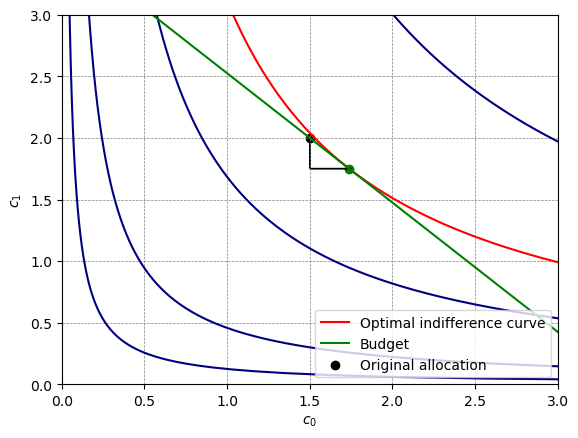

In [6]:
## Solve for the optimal consumption allocation 

## This is a solving function, it takes the problem (problemfun) as input and minimizes it (but the problemfun is inverted, hence it maximizes)
## Because the utility function is not defined for 0, we need to optimize within bounds. 
lowerbound = -y_2/(1+r) #can at most borrow what can be paid back with period 2 income
upperbound = y_1     #can at most save (slightly less than) all income
a1_guess = -0.5 # initial guess: save half
sol = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y_1,y_2,β,r,σ)) 

# Function to recover the solution of the problem, including the optimal indifference curve
def extract_sol(sol, y_1,y_2,r,β,σ,c_vec):
    opt_a = sol.x
    opt_c1= y_1-opt_a #optimal c_1
    opt_c2= y_2 + (1+r)*opt_a #optimal c_2
    opt_U = -problemfun(opt_a,y_1,y_2,β,r,σ) ##Remember: problemfun is inverted
    ## This is the budget constraint 
    c_2_budget = (y_1-c_vec)*(1+r) + y_2
    ## Recover the whole, optimal indifference curve 
    opt_indiff = u_inv(opt_U-β * u(c_vec,σ),σ)
    return opt_a,opt_c1,opt_c2,opt_U, c_2_budget,opt_indiff
    
opt_a,opt_c1,opt_c2,opt_U, c_2_budget,opt_indiff = extract_sol(sol, y_1,y_2,r,β,σ,c_vec)

#Plot
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy') ## plot the indifference curves again
plt.plot(opt_indiff, c_vec, color ='red', label = 'Optimal indifference curve')

plt.plot(c_vec,c_2_budget, color = 'green', label = 'Budget') #plot budget
plt.scatter(opt_c1,opt_c2, color = 'green') #plot optimal allocation
plt.scatter(y_1,y_2, color = 'black', label = 'Original allocation') #original allocation
plt.arrow(y_1,y_2, 0, y_1-opt_c1)
plt.arrow(y_1,opt_c2, y_2-opt_c2, 0)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.legend()
plt.savefig('indiff_solution.pdf')

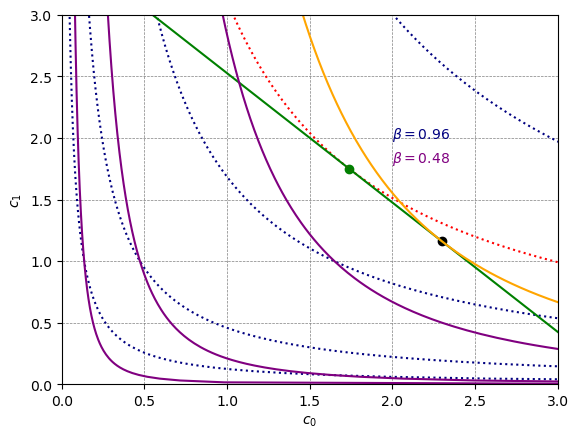

In [7]:
## How does beta affect the indifference curves?
sol_baseline = extract_sol(sol, y_1,y_2,r,β,σ,c_vec)
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy','dotted') ## Ind. curves, original beta
plt.plot(sol_baseline[5], c_vec, color ='red',linestyle = 'dotted')
plt.plot(c_vec,sol_baseline[4], color = 'green', label = 'Budget') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green') #plot optimal allocation



sol2 = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y_1,y_2,β/2,r,σ)) 
plot_indifference(NU, lowb, upb,β/2,σ,c_vec,'purple' ) ## Ind. curves, less patience
sol_impatient = extract_sol(sol2, y_1,y_2,r,β/2,σ,c_vec)
plt.plot(sol_impatient[5], c_vec, color ='orange')
plt.scatter(sol_impatient[1],sol_impatient[2], color = 'black') #plot optimal allocation

plt.annotate(r'$ \beta = $' + str(β),(2,2),color = 'navy')
plt.annotate(r'$ \beta = $' + str(β/2),(2,1.8),color = 'purple')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.savefig('indiff_patience.pdf')


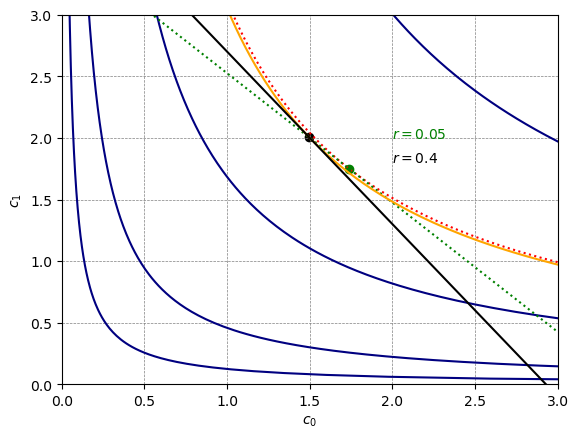

In [8]:
## How does r affect the solution?
sol_baseline = extract_sol(sol, y_1,y_2,r,β,σ,c_vec)
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy') ## Ind. curves, original beta
plt.plot(sol_baseline[5], c_vec, color ='red',linestyle = 'dotted')
plt.plot(c_vec,sol_baseline[4], color = 'green', label = 'Budget',linestyle = 'dotted') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green') #plot optimal allocation

sol3 = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y_1,y_2,β,r*8,σ)) 
sol_r = extract_sol(sol3, y_1,y_2,r*8,β,σ,c_vec)
plt.plot(sol_r[5], c_vec, color ='orange')
plt.scatter(sol_r[1],sol_r[2], color = 'black') #plot optimal allocation
plt.plot(c_vec,sol_r[4], color = 'black', label = 'Budget',linestyle = 'solid') #plot budget

plt.annotate(r'$ r = $' + str(r),(2,2),color = 'green')
plt.annotate(r'$ r = $' + str(r*8),(2,1.8),color = 'black')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.savefig('indiff_r.pdf')


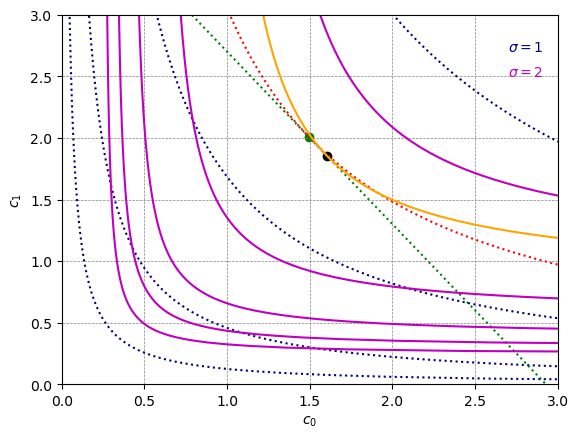

In [9]:
## How does σ affect the solution?
solx = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y_1,y_2,β,r*8,σ)) 
sol_baseline = extract_sol(solx, y_1,y_2,r*8,β,σ,c_vec)
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy','dotted') ## Ind. curves, original beta
plt.plot(sol_baseline[5], c_vec, color ='red',linestyle = 'dotted')
plt.plot(c_vec,sol_baseline[4], color = 'green', label = 'Budget',linestyle = 'dotted') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green') #plot optimal allocation



sol4 = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y_1,y_2,β,r*8,σ*2)) 
c_spec = np.linspace(1,c_max,N)
sol_r = extract_sol(sol4, y_1,y_2,r*8,β,σ*2,c_spec)
plot_indifference_sigma(NU, lowb, 1,β,σ*2,'m') ## Ind. curves, original beta
plt.plot(sol_r[5], c_spec, color ='orange')
plt.scatter(sol_r[1],sol_r[2], color = 'black') #plot optimal allocation

plt.annotate(r'$ \sigma = $' + str(σ),(2.7,2.7),color = 'navy')
plt.annotate(r'$ \sigma = $' + str(σ*2),(2.7,2.5),color = 'm')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

plt.savefig('indiff_sigma.pdf')




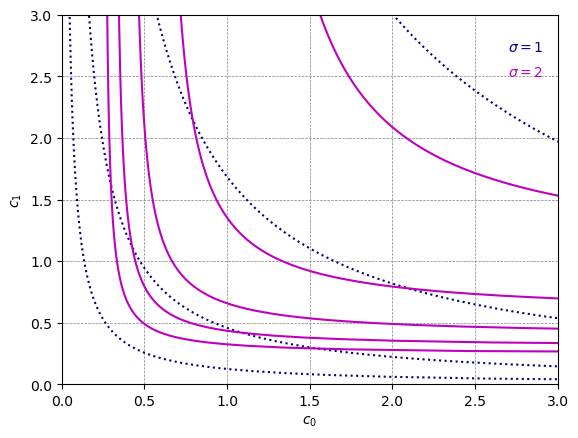

In [10]:
## Plot just the indifference curves
plot_indifference(NU, lowb, upb,β,σ,c_vec,'navy','dotted') ## Ind. curves, original beta
plot_indifference_sigma(NU, lowb, 1,β,σ*2,'m') ## Ind. curves, original beta

plt.annotate(r'$ \sigma = $' + str(σ),(2.7,2.7),color = 'navy')
plt.annotate(r'$ \sigma = $' + str(σ*2),(2.7,2.5),color = 'm')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('indiff_sigma_only.pdf')


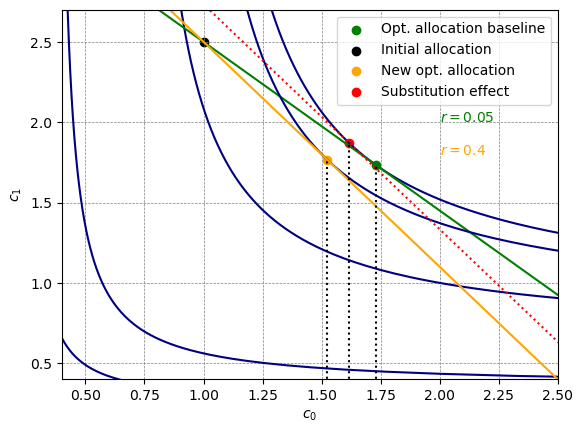

In [11]:
## Income and substitution effect after a change in interest rate for σ = 1
#This is done with larger differences between y0 and y1 to make it clearer

## y1 is larger
y0 = 1
y1 = 2.5
σ = 2
lowerbound = -y1/(1+r) #can at most borrow what can be paid back with period 2 income
upperbound = y0     #can at most save (slightly less than) all income

## Baseline solution
solx = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,r,σ)) 
sol_baseline = extract_sol(solx, y0,y1,r,β,σ,c_vec)
plot_indifference_sigma(NU, lowb, upb,β,σ,'navy' ,ll = 'solid')

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1. The linspace range has to change
c_vec_bl = np.linspace(u_inv((sol_baseline[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_bl = u_inv(sol_baseline[3]-β * u(c_vec_bl,σ),σ)

plt.plot(opt_indiff_bl, c_vec_bl, color ='navy') #Old optimal indifference curve
plt.plot(c_vec,sol_baseline[4], color = 'green') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green', label = 'Opt. allocation baseline') #plot optimal allocation
plt.scatter(y0,y1, color = 'black', label = 'Initial allocation') #initial allocation

## New Solution
rr = r*8
solr = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,rr,σ)) 
sol_newr = extract_sol(solr, y0,y1,rr,β,σ,c_vec)

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1
c_vec_n = np.linspace(u_inv((sol_newr[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_n = u_inv(sol_newr[3]-β * u(c_vec_n,σ),σ)

plt.plot(opt_indiff_n, c_vec_n, color ='navy') #New optimal indifference curve
plt.plot(c_vec,sol_newr[4], color = 'orange') #plot budget
plt.scatter(sol_newr[1],sol_newr[2], color = 'orange', label = 'New opt. allocation') #plot optimal allocation
plt.xlim(0.4,2.5)
plt.ylim(0.4,2.7)

## Substitution effect: same indifference curve but new budget line
def subst_eff(opt_U_bl, y0,y1,β,σ,rr,c_vec):
    ## Where does the new budget constraint meet the old indifference curve?
    # What are the consumption values at the new interest rate that yield the correct level of utility?
    #Combines the Euler equation and the total utility function to solve for c1 and then c0
    if σ==1:
        a = ( opt_U_bl+np.log((1+rr)*β) ) / (1+β)
        c1 = np.exp(a)
        c0 = c1/((1+rr)*β)
    else:
        q = ((1+rr)*β)**(-1/σ)
        m = (q**(1-σ)+β)/(1-σ)
        n = (1+β)/(1-σ)
        c1 = ((opt_U_bl+n)/m)**(1/(1-σ))
        c0 = c1 * q
        
    ## This is the budget constraint 
    b = c1+c0*(1+rr) 
    c1budget = -(1+rr)*c_vec + b
    return c0,c1, c1budget

## Substitution effect (intermediate)
c0sub, c1sub,budget_sub = subst_eff(sol_baseline[3], y0,y1,β,σ,rr,c_vec)
plt.scatter(c0sub,c1sub, color = 'red', label = 'Substitution effect')
plt.plot(c_vec,budget_sub,linestyle = 'dotted', color='red')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

##Explanation
plt.vlines(c0sub,0,c1sub, linestyle = 'dotted', color = 'black')
plt.vlines(sol_baseline[1],0,sol_baseline[2], linestyle = 'dotted', color = 'black')
plt.vlines(sol_newr[1],0,sol_newr[2], linestyle = 'dotted', color = 'black')

#plt.annotate('Substitution effect',xy=(c0sub,0.5),xytext=(sol_baseline[1],0.52),arrowprops={})
#plt.annotate('Income effect',xy=(sol_newr[1],0.7),xytext=(c0sub,0.72),arrowprops={},ha='left')
plt.legend(loc='upper right')

plt.annotate(r'$ r = $' + str(r),(2,2),color = 'green')
plt.annotate(r'$ r = $' + str(rr),(2,1.8),color = 'orange')

plt.savefig('income_subs1.pdf')


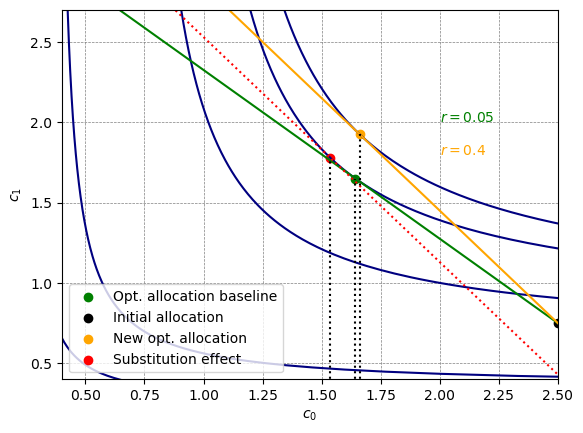

In [12]:
# y0 is larger

y0 = 2.5
y1 = .75
σ = 2
lowerbound = -y1/(1+r) #can at most borrow what can be paid back with period 2 income
upperbound = y0     #can at most save (slightly less than) all income

## Baseline solution
solx = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,r,σ)) 
sol_baseline = extract_sol(solx, y0,y1,r,β,σ,c_vec)
plot_indifference_sigma(NU, lowb, upb,β,σ,'navy' ,ll = 'solid')

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1. The linspace range has to change
c_vec_bl = np.linspace(u_inv((sol_baseline[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_bl = u_inv(sol_baseline[3]-β * u(c_vec_bl,σ),σ)

plt.plot(opt_indiff_bl, c_vec_bl, color ='navy') #Old optimal indifference curve
plt.plot(c_vec,sol_baseline[4], color = 'green') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green', label = 'Opt. allocation baseline') #plot optimal allocation
plt.scatter(y0,y1, color = 'black', label = 'Initial allocation') #initial allocation

## New Solution
rr = r*8
solr = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,rr,σ)) 
sol_newr = extract_sol(solr, y0,y1,rr,β,σ,c_vec)

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1
c_vec_n = np.linspace(u_inv((sol_newr[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_n = u_inv(sol_newr[3]-β * u(c_vec_n,σ),σ)

plt.plot(opt_indiff_n, c_vec_n, color ='navy') #New optimal indifference curve
plt.plot(c_vec,sol_newr[4], color = 'orange') #plot budget
plt.scatter(sol_newr[1],sol_newr[2], color = 'orange', label = 'New opt. allocation') #plot optimal allocation
plt.xlim(0.4,2.5)
plt.ylim(0.4,2.7)

## Substitution effect (intermediate)
c0sub, c1sub,budget_sub = subst_eff(sol_baseline[3], y0,y1,β,σ,rr,c_vec)
plt.scatter(c0sub,c1sub, color = 'red', label = 'Substitution effect')
plt.plot(c_vec,budget_sub,linestyle = 'dotted', color='red')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

##Explanation
plt.vlines(c0sub,0,c1sub, linestyle = 'dotted', color = 'black')
plt.vlines(sol_baseline[1],0,sol_baseline[2], linestyle = 'dotted', color = 'black')
plt.vlines(sol_newr[1],0,sol_newr[2], linestyle = 'dotted', color = 'black')

#plt.annotate('Substitution effect',xy=(c0sub,0.5),xytext=(sol_baseline[1],0.52),arrowprops={})
#plt.annotate('Income effect',xy=(sol_newr[1],0.7),xytext=(c0sub,0.72),arrowprops={},ha='left')
plt.legend(loc='lower left')

plt.annotate(r'$ r = $' + str(r),(2,2),color = 'green')
plt.annotate(r'$ r = $' + str(rr),(2,1.8),color = 'orange')
plt.savefig('income_subs0.pdf')


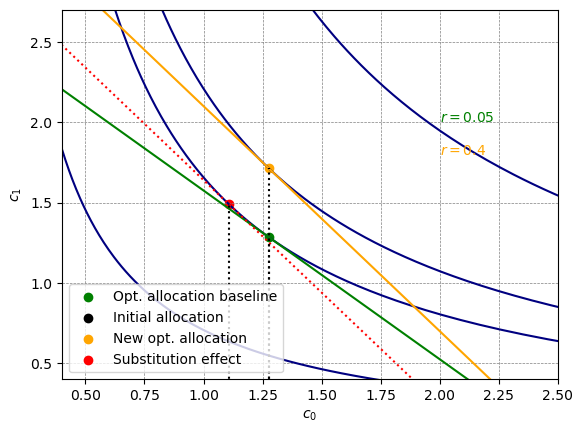

In [17]:
# y0 is larger

y0 = 2.5
y1 = 0
σ = 1
NU = 4
lowerbound = -y1/(1+r) #can at most borrow what can be paid back with period 2 income
upperbound = y0     #can at most save (slightly less than) all income

## Baseline solution
solx = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,r,σ)) 
sol_baseline = extract_sol(solx, y0,y1,r,β,σ,c_vec)
plot_indifference_sigma(NU, lowb, upb,β,σ,'navy' ,ll = 'solid')

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1. The linspace range has to change
c_vec_bl = np.linspace(u_inv((sol_baseline[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_bl = u_inv(sol_baseline[3]-β * u(c_vec_bl,σ),σ)

plt.plot(opt_indiff_bl, c_vec_bl, color ='navy') #Old optimal indifference curve
plt.plot(c_vec,sol_baseline[4], color = 'green') #plot budget
plt.scatter(sol_baseline[1],sol_baseline[2], color = 'green', label = 'Opt. allocation baseline') #plot optimal allocation
plt.scatter(y0,y1, color = 'black', label = 'Initial allocation') #initial allocation

## New Solution
rr = r*8
solr = optimize.minimize_scalar(problemfun, a1_guess, bounds=(lowerbound , upperbound), args=(y0,y1,β,rr,σ)) 
sol_newr = extract_sol(solr, y0,y1,rr,β,σ,c_vec)

## Have to redraw the indifference curve, because things get wonky close to c=0 with σ>1
c_vec_n = np.linspace(u_inv((sol_newr[3] - u(1000,σ))/β,σ ),c_max,N)
opt_indiff_n = u_inv(sol_newr[3]-β * u(c_vec_n,σ),σ)

plt.plot(opt_indiff_n, c_vec_n, color ='navy') #New optimal indifference curve
plt.plot(c_vec,sol_newr[4], color = 'orange') #plot budget
plt.scatter(sol_newr[1],sol_newr[2], color = 'orange', label = 'New opt. allocation') #plot optimal allocation
plt.xlim(0.4,2.5)
plt.ylim(0.4,2.7)

## Substitution effect (intermediate)
c0sub, c1sub,budget_sub = subst_eff(sol_baseline[3], y0,y1,β,σ,rr,c_vec)
plt.scatter(c0sub,c1sub, color = 'red', label = 'Substitution effect')
plt.plot(c_vec,budget_sub,linestyle = 'dotted', color='red')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

##Explanation
plt.vlines(c0sub,0,c1sub, linestyle = 'dotted', color = 'black')
plt.vlines(sol_baseline[1],0,sol_baseline[2], linestyle = 'dotted', color = 'black')
plt.vlines(sol_newr[1],0,sol_newr[2], linestyle = 'dotted', color = 'black')

#plt.annotate('Substitution effect',xy=(c0sub,0.5),xytext=(sol_baseline[1],0.52),arrowprops={})
#plt.annotate('Income effect',xy=(sol_newr[1],0.7),xytext=(c0sub,0.72),arrowprops={},ha='left')
plt.legend(loc='lower left')

plt.annotate(r'$ r = $' + str(r),(2,2),color = 'green')
plt.annotate(r'$ r = $' + str(rr),(2,1.8),color = 'orange')
plt.savefig('income_subs_log.pdf')
